In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the simple fully connected network
class CIFAR10_FCN(nn.Module):
    def __init__(self):
        super(CIFAR10_FCN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 32 * 32, 1024),  # Input size: 3 channels * 32x32 pixels
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        return self.classifier(x)

# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset with GPU transfer
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                    download=True, transform=transform)

# Split training set into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                      shuffle=True, num_workers=2, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=128,
                                     shuffle=False, num_workers=2, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                   download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                     shuffle=False, num_workers=2, pin_memory=True)


print(CIFAR10_FCN())


Files already downloaded and verified
Files already downloaded and verified
CIFAR10_FCN(
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3072, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=256, bias=True)
    (6): ReLU()
    (7): Linear(in_features=256, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


Training started...
Epoch 1 - Train Acc: 38.17%, Val Acc: 44.13%
Epoch 10 - Train Acc: 74.27%, Val Acc: 54.61%
Epoch 20 - Train Acc: 90.97%, Val Acc: 53.97%
Test Accuracy: 52.87%
Precision: 0.537
Recall: 0.529
F1 Score: 0.530


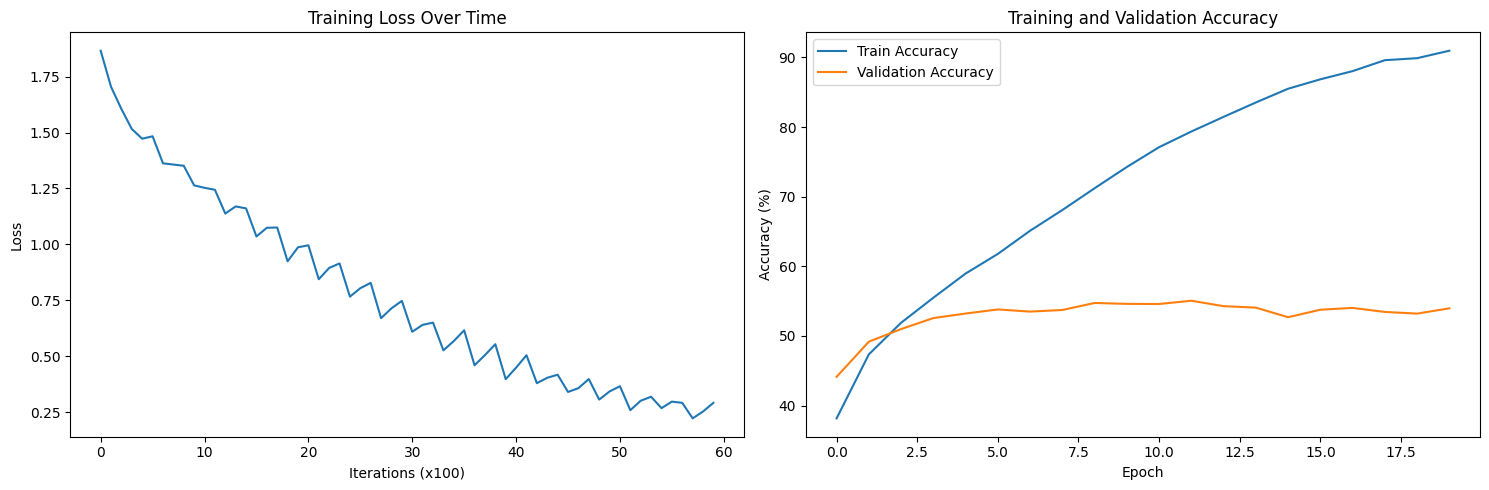

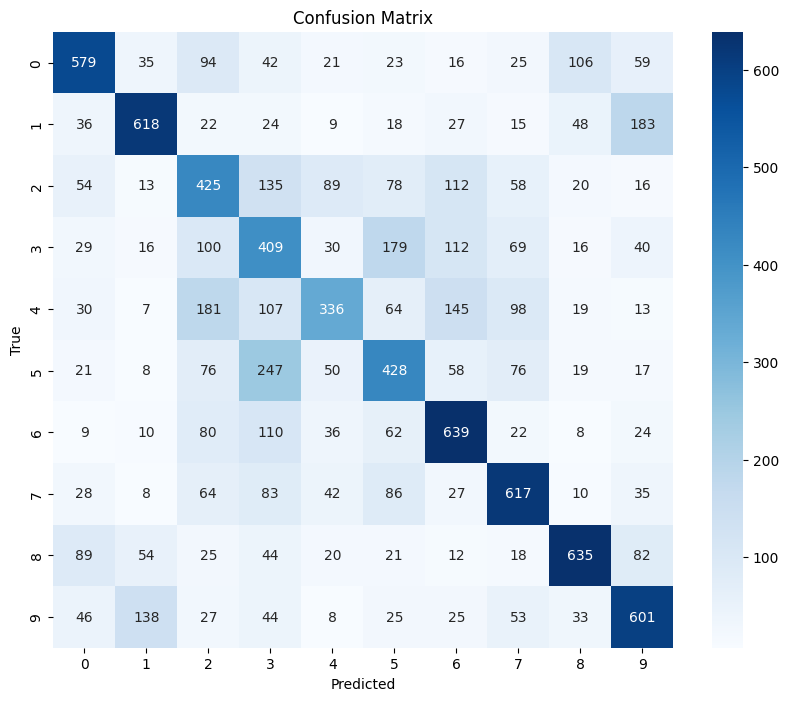

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # define accelerator
EPOCHS = 20
net = CIFAR10_FCN().to(device) # send model to accelerator
criterion = nn.CrossEntropyLoss() # define loss function
optimizer = optim.Adam(net.parameters(), lr=0.001) # define optimizer

# Training loop with reduced print frequency
def train(epochs):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if i % 100 == 99:
                train_losses.append(running_loss / 100)
                running_loss = 0.0
        
        # Calculate epoch accuracies
        train_acc = 100 * correct / total
        val_acc = evaluate(valloader)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f'Epoch {epoch + 1} - Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')
    
    return train_losses, train_accuracies, val_accuracies

# Evaluation function
def evaluate(dataloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

# Function to get predictions and true labels
def get_predictions(dataloader):
    net.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Train the model
print("Training started...")
train_losses, train_accuracies, val_accuracies = train(EPOCHS)

# Save the model
torch.save(net.state_dict(), 'cifar10_fcn.pth')

# Evaluate on test set and calculate metrics
test_accuracy = evaluate(testloader)
y_pred, y_true = get_predictions(testloader)

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print results
print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')

# Plot training loss
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Iterations (x100)')
plt.ylabel('Loss')

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Epoch [20/200], Train Loss: 0.7032, Val Loss: 1.2328
Epoch [40/200], Train Loss: 0.4033, Val Loss: 0.7461
Epoch [60/200], Train Loss: 0.2744, Val Loss: 0.5403
Epoch [80/200], Train Loss: 0.2341, Val Loss: 0.4965
Epoch [100/200], Train Loss: 0.2107, Val Loss: 0.4950
Epoch [120/200], Train Loss: 0.1911, Val Loss: 0.4898
Epoch [140/200], Train Loss: 0.1723, Val Loss: 0.4833
Epoch [160/200], Train Loss: 0.1539, Val Loss: 0.4794
Epoch [180/200], Train Loss: 0.1362, Val Loss: 0.4824
Epoch [200/200], Train Loss: 0.1181, Val Loss: 0.4864
Final Validation MAE: 0.5299
Model Complexity: 3457 parameters


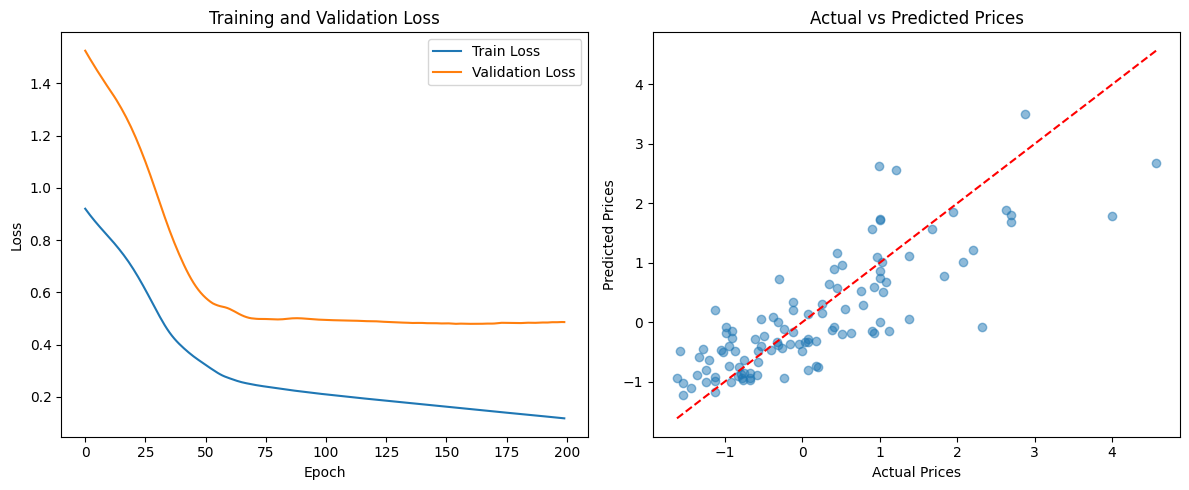

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)

# Load housing data
data = pd.read_csv('data/Housing.csv')

# Convert categorical variables to numerical
data['mainroad'] = data['mainroad'].map({'yes': 1, 'no': 0})
data['guestroom'] = data['guestroom'].map({'yes': 1, 'no': 0})
data['basement'] = data['basement'].map({'yes': 1, 'no': 0})
data['hotwaterheating'] = data['hotwaterheating'].map({'yes': 1, 'no': 0})
data['airconditioning'] = data['airconditioning'].map({'yes': 1, 'no': 0})
data['prefarea'] = data['prefarea'].map({'yes': 1, 'no': 0})
data['furnishingstatus'] = data['furnishingstatus'].map({'furnished': 1, 'semi-furnished': 0.5, 'unfurnished': 0})

# Prepare data
X = data.drop('price', axis=1).values
y = data['price'].values.reshape(-1, 1)

# Normalize data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

# Define the network
class HousingFCN(nn.Module):
    def __init__(self, input_size):
        super(HousingFCN, self).__init__()
        self.regressor = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        return self.regressor(x)

# Initialize model, loss, and optimizer
input_size = X_train.shape[1]
model = HousingFCN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 200
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    # Store losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Calculate final accuracy
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    mae = torch.mean(torch.abs(predictions - y_val)).item()
    print(f'Final Validation MAE: {mae:.4f}')

# Model complexity
total_params = sum(p.numel() for p in model.parameters())
print(f'Model Complexity: {total_params} parameters')

plt.subplot(1, 2, 2)
plt.scatter(y_val.numpy(), predictions.numpy(), alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.tight_layout()
plt.show()


Epoch [20/200], Train Loss: 0.6886, Val Loss: 1.2176
Epoch [40/200], Train Loss: 0.4038, Val Loss: 0.7627
Epoch [60/200], Train Loss: 0.2681, Val Loss: 0.4994
Epoch [80/200], Train Loss: 0.2277, Val Loss: 0.4665
Epoch [100/200], Train Loss: 0.1999, Val Loss: 0.4775
Epoch [120/200], Train Loss: 0.1767, Val Loss: 0.4878
Epoch [140/200], Train Loss: 0.1554, Val Loss: 0.4993
Epoch [160/200], Train Loss: 0.1350, Val Loss: 0.5038
Epoch [180/200], Train Loss: 0.1160, Val Loss: 0.5132
Epoch [200/200], Train Loss: 0.0987, Val Loss: 0.5264
Final Validation MAE: 0.5453
Model Complexity: 3521 parameters


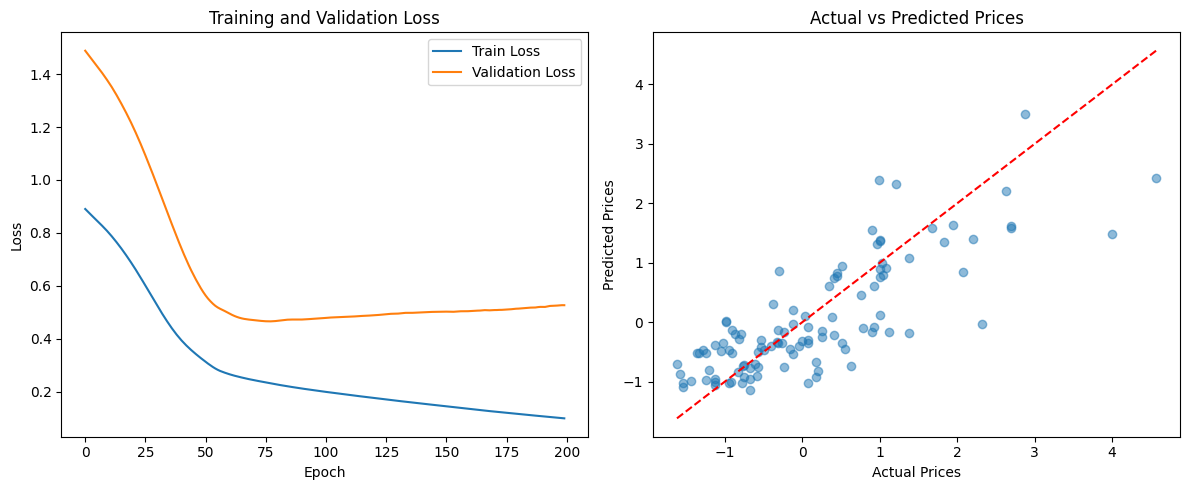

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)

# Load housing data
data = pd.read_csv('data/Housing.csv')

# Convert categorical variables using one-hot encoding
data = pd.get_dummies(data, columns=['mainroad', 'guestroom', 'basement', 
                                    'hotwaterheating', 'airconditioning', 
                                    'prefarea', 'furnishingstatus'], 
                     drop_first=True)

# Prepare data
X = data.drop('price', axis=1).values
y = data['price'].values.reshape(-1, 1)

# Normalize data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

# Define the network
class HousingFCN(nn.Module):
    def __init__(self, input_size):
        super(HousingFCN, self).__init__()
        self.regressor = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
        
    def forward(self, x):
        return self.regressor(x)

# Initialize model, loss, and optimizer
input_size = X_train.shape[1]
model = HousingFCN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 200
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    # Store losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Calculate final accuracy
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    mae = torch.mean(torch.abs(predictions - y_val)).item()
    print(f'Final Validation MAE: {mae:.4f}')

# Model complexity
total_params = sum(p.numel() for p in model.parameters())
print(f'Model Complexity: {total_params} parameters')

plt.subplot(1, 2, 2)
plt.scatter(y_val.numpy(), predictions.numpy(), alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
torch.manual_seed(42)

# Load housing data
data = pd.read_csv('data/Housing.csv')

# Convert categorical variables using one-hot encoding
data = pd.get_dummies(data, columns=['mainroad', 'guestroom', 'basement', 
                                    'hotwaterheating', 'airconditioning', 
                                    'prefarea', 'furnishingstatus'], 
                     drop_first=True)

# Prepare data
X = data.drop('price', axis=1).values
y = data['price'].values.reshape(-1, 1)

# Normalize data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val)

# Define the network
class HousingFCN(nn.Module):
    def __init__(self, input_size):
        super(HousingFCN, self).__init__()
        self.regressor = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 48),
            nn.ReLU(),
            nn.Linear(48, 32),
            nn.ReLU(),
            nn.Linear(32, 24),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        return self.regressor(x)

# Initialize model, loss, and optimizer
input_size = X_train.shape[1]
model = HousingFCN(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training parameters
epochs = 200
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, y_val)
    
    # Store losses
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Calculate final accuracy
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    mae = torch.mean(torch.abs(predictions - y_val)).item()
    print(f'Final Validation MAE: {mae:.4f}')

# Model complexity
total_params = sum(p.numel() for p in model.parameters())
print(f'Model Complexity: {total_params} parameters')

plt.subplot(1, 2, 2)
plt.scatter(y_val.numpy(), predictions.numpy(), alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.tight_layout()
plt.show()
